# Previsão de séries temporais com *Auto Machine Learning*

Nesse pequeno projeto será usada a biblioteca *Pycaret* para modelagem de séries temporais de preços de ações. Aqui será usado o módulo de regressão dessa biblioteca e para isso iremos transformar a série temporal em um formato tabular; isso é necessário, pois modelos de regressão estimam a relação entre as variáveis explicativas ou independentes (*features*) com a variável dependente ou a ser explicada (*target*). O objetivo desses tipos de modelos é prever valores contínuos e o módulo de regressão da *Pycaret* permite que sejam realizados pré-processamento dos dados e a aplicação de cerca de 25 modelos de regressão.

## Instalação da biblioteca *Pycaret*

In [1]:
pip install pycaret

     |████████████████████████████████| 266kB 6.7MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 112kB 8.4MB/s 
     |████████████████████████████████| 2.0MB 9.4MB/s 
     |████████████████████████████████| 14.2MB 201kB/s 
     |████████████████████████████████| 256kB 37.1MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 174kB 46.8MB/s 
     |████████████████████████████████| 1.7MB 39.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8MB 30.8MB/s 
     |████████████████████████████████| 276kB 38.3MB/s 
     |████████████████████████████████| 1.4MB 30.5MB/s 
     |████████████████████████████████| 1.2MB 29.7MB/s 
     |████████████████████████████████| 1.1MB 24.9MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 


## Importação das bibliotecas



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb

from pycaret.regression import *
from pycaret.utils import check_metric
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_log_error, mean_squared_error, mean_absolute_error

## Importação dos dados

Aqui iremos usar a série de preços de fechamento da ação *BBDC4.SA*, extraídos do *Yahoo Finance*; essa ação é do banco Bradesco, um dos maiores bancos do Brasil. A série tem periodicidade diária e vai de 01 de Janeiro de 2019 até 01 de Junho de 2021, com 595 observações. Mais informações sobre essa ação podem ser acessadas [aqui](https://finance.yahoo.com/quote/BBDC4.SA/key-statistics?p=BBDC4.SA).

Abaixo uso a biblioteca *Pandas Data Reader* para a extração desses dados.

In [3]:
tickers=['BBDC4.SA']
newdata=pd.DataFrame()
for t in tickers:
    newdata[t]=wb.DataReader(t,data_source='yahoo',start='2019-1-1',end='2021-06-01')['Adj Close']

Primeiras observações da série temporal.

In [4]:
newdata.head()

,BBDC4.SA
Date,
2019-01-02,27.688560
2019-01-03,27.967863
2019-01-04,27.748400
2019-01-07,28.077600
2019-01-08,28.249056


Últimas observações da série.

In [5]:
newdata.tail()

,BBDC4.SA
Date,
2021-05-26,26.301559
2021-05-27,26.461447
2021-05-28,26.521406
2021-05-31,26.461447
2021-06-01,27.061026


Não há valores faltantes na série.

In [6]:
newdata.isna().sum()

BBDC4.SA    0
dtype: int64

Tabela estatística da série temporal.

In [7]:
newdata.describe()

,BBDC4.SA
count,595.000000
mean,25.570040
std,4.286247
min,15.631574
25%,21.783693
50%,26.461447
75%,29.323227
max,33.087223


Dimensão da série.

In [8]:
newdata.shape

(595, 1)

Abaixo temos o gráfico da série.

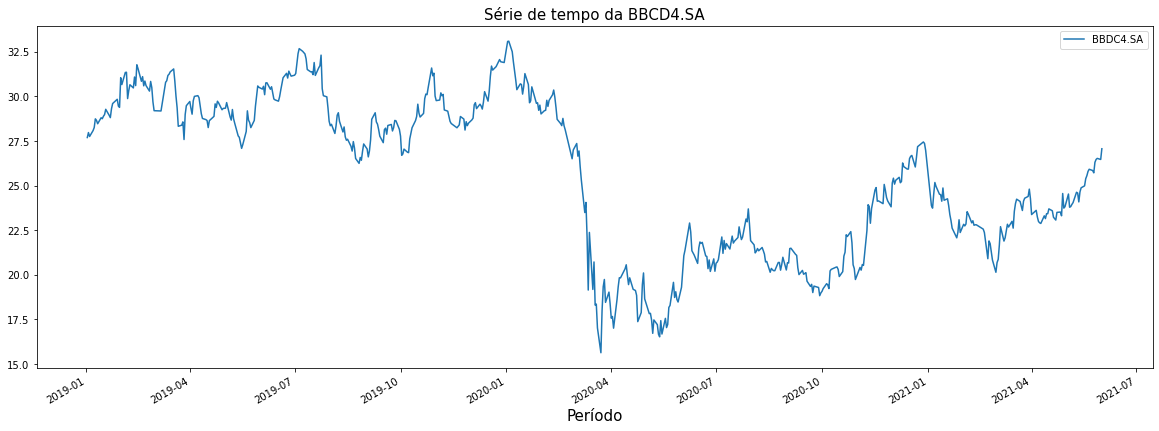

In [9]:
newdata.plot(figsize=(20,7))
plt.title('Série de tempo da BBCD4.SA', size=15)
plt.xlabel('Período', size=15);

## Conversão de série temporal

Como dito anteriormente é ncessário transformar a série em uma estrutura para serem usados os modelos de regressão, por isso é do nosso interesse que os dados estajam no formato supervisionado (variáveis explicativas e variável a ser explicada).

Para isso irei criar duas listas vazias.

In [10]:
x_data = []
y_data = []

Formatando a série para que cada linha da base de dados *x_data* seja composta pelos 5 dias anteriores.

In [11]:
for d in range(5,newdata.shape[0]):
    x = newdata.iloc[d-5:d].values.ravel()
    y = newdata.iloc[d].values[0]
    x_data.append(x)
    y_data.append(y)

Agora vamos transformar *X* e *y* em um único *dataset*.

In [12]:
y = pd.DataFrame(y_data)
X = pd.DataFrame(x_data)
X['target']=y

Primeiras linhas da nova base de dados.

In [13]:
X.head()

,0,1,2,3,4,target
0,27.688560,27.967863,27.748400,28.077600,28.249056,28.735987
1,27.967863,27.748400,28.077600,28.249056,28.735987,28.646828
2,27.748400,28.077600,28.249056,28.735987,28.646828,28.461657
3,28.077600,28.249056,28.735987,28.646828,28.461657,28.797709
4,28.249056,28.735987,28.646828,28.461657,28.797709,28.742849


Últimas linhas.

In [14]:
X.tail()

,0,1,2,3,4,target
585,25.552084,25.791916,25.911833,25.841881,25.711971,26.301559
586,25.791916,25.911833,25.841881,25.711971,26.301559,26.461447
587,25.911833,25.841881,25.711971,26.301559,26.461447,26.521406
588,25.841881,25.711971,26.301559,26.461447,26.521406,26.461447
589,25.711971,26.301559,26.461447,26.521406,26.461447,27.061026


Dimensões da nova base de dados.

In [15]:
X.shape

(590, 6)

## Separando os dados de treino e teste

Aqui não usaremos o *train_test_split*, pois essa função aleatoriza os dados de treino e teste. Como é uma série temporal é necessário que a ordem dos dados seja mantida, por isso os dados para teste serão as 119 últimas observações e o que estiver antes, será para treino.

In [16]:
x_treino = X[:-119]
x_teste = X[-119:]

## Modelagem de *Auto Machine Learning*

Passaremos para as configurações da função a base de treino, a variável alvo e a parte dos dados usada para treino, porém diferente do convencional usarei o parâmetro *fold_strategy* para séries temporais.

In [17]:
reg1 = setup(data =x_treino, target = 'target', fold_strategy='timeseries' ,train_size = 0.8)

,Description,Value
0,session_id,4690
1,Target,target
2,Original Data,"(471, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(376, 5)"


Usando os modelos : agora usarei todos os modelos possíveis e irei ordenar os melhores modelos pela métrica *MAE* (*Mean Absolute Error*), mas é possível usar outras métricas.

O melhor modelo foi o *Orthogonal Matching Pursuit	* que tem como código a sigla *omp*. Coincidentemente as outras métricas desse modelo apresentaram um melhor desempenho do que as dos outros modelos.

In [19]:
best = compare_models(turbo=False, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.4753,0.4213,0.6374,0.9797,0.0272,0.0198,0.017
kr,Kernel Ridge,0.4954,0.4538,0.6643,0.9781,0.0285,0.0207,0.015
huber,Huber Regressor,0.4963,0.4401,0.6548,0.9787,0.0279,0.0208,0.041
ard,Automatic Relevance Determination,0.5002,0.4586,0.6667,0.9779,0.0285,0.0209,0.018
ransac,Random Sample Consensus,0.5015,0.4555,0.6677,0.9779,0.0286,0.0210,0.020
tr,TheilSen Regressor,0.5051,0.4664,0.6720,0.9775,0.0288,0.0212,0.586
ridge,Ridge Regression,0.5093,0.4750,0.6800,0.9772,0.0291,0.0214,0.015
br,Bayesian Ridge,0.5093,0.4747,0.6797,0.9772,0.0291,0.0214,0.017
lr,Linear Regression,0.5142,0.4867,0.6879,0.9766,0.0295,0.0216,0.016
lar,Least Angle Regression,0.5142,0.4867,0.6879,0.9766,0.0295,0.0216,0.018


Abaixo temos a validação cruzada realizada pelo modelo.

In [20]:
omp = create_model('omp')
print(omp)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3833,0.2570,0.5070,0.9880,0.0212,0.0160
1,0.4230,0.3211,0.5667,0.9873,0.0261,0.0187
2,0.5404,0.4388,0.6624,0.9761,0.0286,0.0228
3,0.3943,0.3313,0.5756,0.9871,0.0277,0.0175
4,0.3877,0.2267,0.4761,0.9834,0.0180,0.0149
5,0.5751,0.5050,0.7107,0.9772,0.0292,0.0239
6,0.5607,0.5726,0.7567,0.9735,0.0321,0.0234
7,0.6630,0.7978,0.8932,0.9629,0.0375,0.0278
8,0.4526,0.4757,0.6897,0.9777,0.0303,0.0186
9,0.3730,0.2870,0.5357,0.9835,0.0212,0.0148


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)


Realizando o *Tunning* do modelo: realizamos automaticamente uma busca para que fossem encontrados outros parâmetros para melhorar o desempenho do modelo. O resultado mostra que houve uma ligeira piora em algumas métricas e de seus desvios-padrão.

Sendo assim, ficamos com o modelo anterior.

In [22]:
tune_omp = tune_model(omp)
print(tune_omp)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4172,0.3269,0.5717,0.9847,0.0239,0.0174
1,0.4484,0.3036,0.5510,0.9880,0.0253,0.0199
2,0.5127,0.4018,0.6339,0.9781,0.0270,0.0215
3,0.3738,0.3605,0.6005,0.9860,0.0300,0.0164
4,0.3917,0.2377,0.4875,0.9826,0.0185,0.0152
5,0.5769,0.5091,0.7135,0.9770,0.0294,0.0240
6,0.5594,0.5543,0.7445,0.9744,0.0315,0.0232
7,0.6774,0.8141,0.9023,0.9621,0.0378,0.0283
8,0.4660,0.5241,0.7240,0.9755,0.0320,0.0192
9,0.3826,0.2893,0.5379,0.9834,0.0212,0.0151


OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=2,
                          normalize=False, precompute='auto', tol=None)


Aqui vemos o desempenho do modelo sendo usado nos dados de treino e teste. Nos dados de treino a métrica de *R²* foi de 0.981 e o de teste 0.984; como os valores estão bem próximos podemos afastar a suspeita de *overfitting* e de *underfitting*. 

Os resíduos apresentam estar concentrados em torno de zero, então o modelo apresenta ter um bom desempenho.

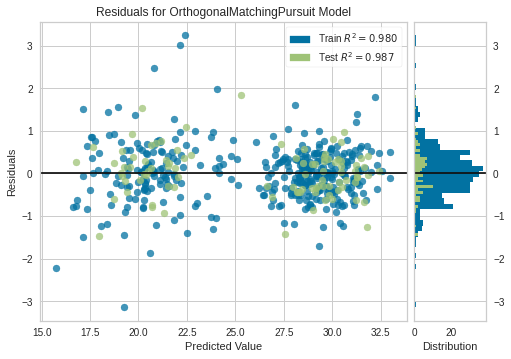

In [23]:
plot_model(omp)

Esse gráfico compara o modelo gerado (*best fit*) com um modelos ideal (*identity*), onde no eixo x estão os valores reais e no eixo y os valores preditos (no modelo ideal os valores preditos são idênticos aos valores reais). Como as retas estão praticamente coincidindo, temos uma evidência do bom desempenho do modelo. 

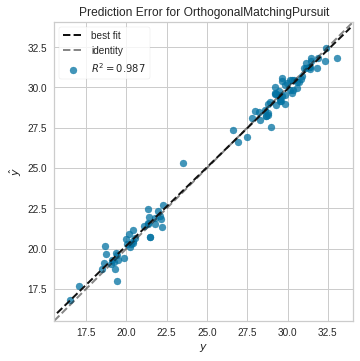

In [24]:
plot_model(omp, plot='error')

A distância de *Cook* é uma medida da influência de uma observação ou instâncias em uma regressão linear. Instâncias com grande influência podem ser *outliers*, e conjuntos de dados com um grande número de pontos altamente influentes podem não ser adequados para regressão linear sem processamento adicional, como remoção de *outlier* ou imputação. 

Os pontos destacados no gráfico são dados discrepantes e vemos que temos muito desses por volta das observações 290 a 300.

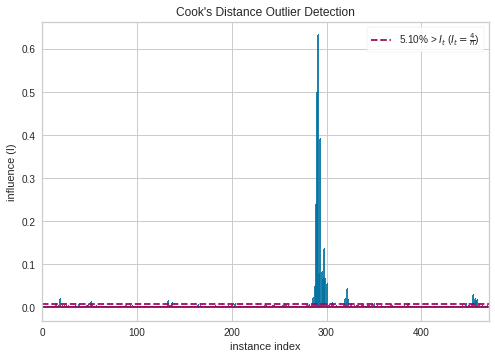

In [25]:
plot_model(omp, plot='cooks')

Aqui vemos qual(is) a(s) variável(is) mais importante(s) para o nosso modelo, que foi a variável 4. Conforme o gráfico abaixo, a variável 4 tem, praticamente, 100% de importância para o modelo.

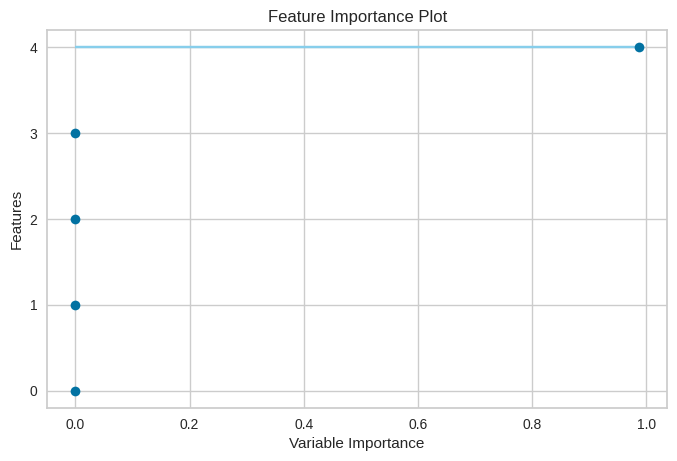

In [26]:
plot_model(omp, plot='feature')

Curva de aprendizado do modelo.

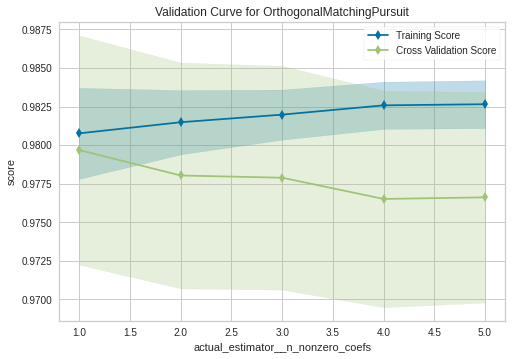

In [27]:
plot_model(omp, plot='vc')

Parâmetros do modelo.

In [28]:
plot_model(omp, plot='parameter')

,Parameters
fit_intercept,True
n_nonzero_coefs,None
normalize,True
precompute,auto
tol,None


## Previsões com o modelo

Nessa última etapa serão geradas as previsões do modelo abaixo.

In [29]:
predict_model(omp)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.425,0.3058,0.553,0.9873,0.0225,0.0173


,0,1,2,3,4,target,Label
0,28.340773,28.937941,29.078938,28.597885,28.000713,28.282709,27.971976
1,31.693594,31.467339,31.661310,32.058071,31.934637,31.890541,31.854910
2,29.994816,30.036028,29.920654,29.492147,29.022451,28.758768,28.980471
3,21.776262,21.883675,22.088747,22.684416,22.293810,21.971563,22.339043
4,28.461657,28.797709,28.742849,28.880011,28.976025,29.270927,28.934646
...,...,...,...,...,...,...,...
90,28.355537,28.492146,28.679989,28.780146,29.523367,29.642956,29.474894
91,28.030712,29.184923,28.665533,28.525375,28.245066,28.649036,28.213161
92,21.368221,21.758511,22.900101,22.392723,21.348707,21.104778,21.406190
93,28.525375,28.245066,28.649036,29.440487,30.025835,30.578209,29.970849


Abaixo pode-se ver graficamente os valores preditos e os valores reais.

Não há necessidade importar funções para avaliar os resultados, pois isso já é feito abaixo. 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.425,0.3058,0.553,0.9873,0.0225,0.0173


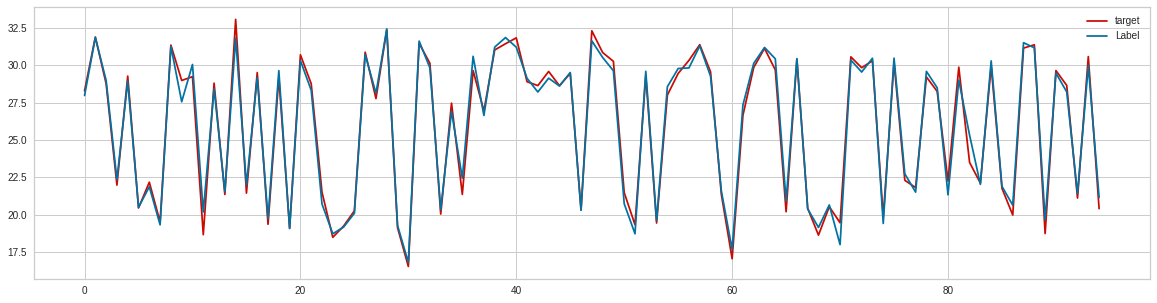

In [30]:
predict_model(omp)[['target','Label']].plot(color=['r','b'],figsize=(20,5));

## Finalizando o modelo

Agora o modelo será treinado com todos os dados de treino (retreino). Abaixo vemos o modelo retreinado com os parâmetros escolhidos pela biblioteca.

In [37]:
final_omp=finalize_model(omp)
print(final_omp)

OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)


E podemos criar as previsões para esse modelo retreinado.

In [39]:
predict_model(final_omp);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.4231,0.3035,0.5509,0.9874,0.0224,0.0172


Agora podemos usar esse modelo para uma etapa de validação: temos dados de uma base que o modelo não teve contato e podemos usar para avaliar se o modelo gera boa previsões.

Temos abaixo o *dataset* de teste, mas com uma variável a mais (*Label*), que é o resultado da inserção das variáveis explicativas (0,1,2,3 e 4) no modelo que encontramos.

In [40]:
predicoes = predict_model(final_omp, data=x_teste)
predicoes.head()

,0,1,2,3,4,target,Label
471,24.336914,24.140966,23.807854,25.140306,25.412127,25.078787,25.411259
472,24.140966,23.807854,25.140306,25.412127,25.078787,25.294479,25.081135
473,23.807854,25.140306,25.412127,25.078787,25.294479,25.461143,25.294747
474,25.140306,25.412127,25.078787,25.294479,25.461143,25.157219,25.459803
475,25.412127,25.078787,25.294479,25.461143,25.157219,25.225843,25.158810


Abaixo temos um gráfico com os valores reais e preditos.

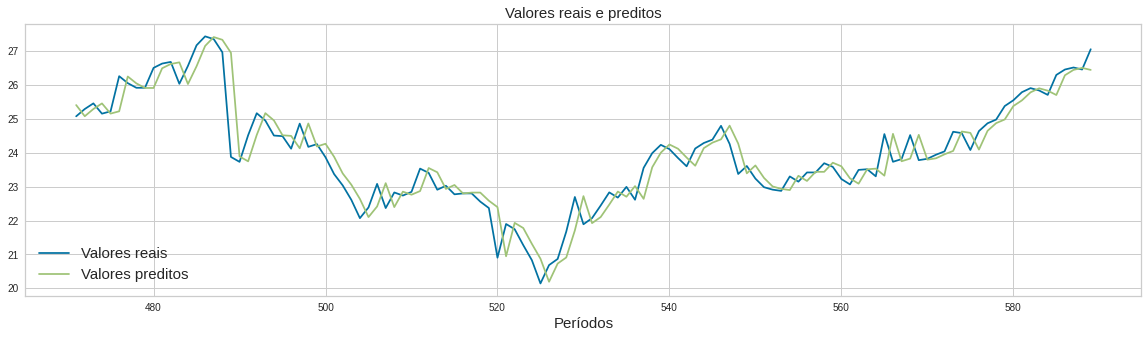

In [58]:
predicoes['target'].plot(figsize=(20,5))
predicoes['Label'].plot()
plt.legend(['Valores reais','Valores preditos'], fontsize=15)
plt.xlabel('Períodos',size=15)
plt.title('Valores reais e preditos',size=15);
#x_treino['target'].plot();

## Avaliação do modelo

Vemos que o modelo não gerou as métricas, então podemos avaliar usando as métricas da biblioteca *SKlearn*.

Vemos abaixo que o coeficiente de determinação está abaixo de 90 (diferente dos resultados de antes), porém ainda sim é um bom resultado. As demais métricas de erros estão abaixo de 1, o que mostra que os resultados são satisfatórios.

In [55]:
print('Coeficiente de determinação :',r2_score(predicoes['Label'],predicoes['target']))
print('Erro absoluto mediano :',median_absolute_error(predicoes['Label'],predicoes['target']))
print('Erro absoluto logatítmico médio :',mean_squared_log_error(predicoes['Label'],predicoes['target']))
print('Erro quadrado médio :',mean_squared_error(predicoes['Label'],predicoes['target']))
print('Erro absoluto mediano :',mean_absolute_error(predicoes['Label'],predicoes['target']))

Coeficiente de determinação : 0.8762244801668744
Erro absoluto mediano : 0.28260064626251946
Erro absoluto logatítmico médio : 0.00046887869883357835
Erro quadrado médio : 0.2905037230429064
Erro absoluto mediano : 0.38426699295407696


## Conclusão

Vemos que a biblioteca *Pycaret* pode ser útil para modelagem de séries temporais, usando as defasagens da variável como regressores. Assim como outros projetos desenvolvidos, a grande vantagem dessa biblioteca é o tempo de pré-processamento dos dados que é muito menor do que realizar toda uma codificação e a escolha do modelo de forma mais automatizada.

Enquanto essa biblioteca ainda não tem um módulo exclusivo para séries temporais (expectativa para a implementação desse novo módulo é para Julho de 2021) isso se torna uma alternativa de modelagem e previsão.